In [1]:
import numpy as np
import matplotlib.pyplot as plt
import legwork as lw
import astropy.units as u
import tqdm
from matplotlib import colors
from astropy.cosmology import Planck18, z_at_value
from scipy.integrate import trapz, cumtrapz
from schwimmbad import MultiPool
from utils import get_LISA_norm, get_LISA_norm_circular, dTmerger_df_circ, get_t_evol_LISA, dTmerger_df, dg_de
from utils import get_t_evol_from_f
from scipy.interpolate import interp1d

In [2]:
def ligo_rate(m1):
    dat = np.array([[3.705799151343708, 0.001087789470121345],
                   [4.384724186704389, 0.00984816875074369],
                   [5.063649222065067, 0.06979974252228799],
                   [5.827439886845831, 0.41173514594201527],
                   [6.506364922206512, 1.3579705933006465],
                   [6.845827439886847, 2.148948034692836],
                   [7.77934936350778, 2.7449738151212433],
                   [8.543140028288544, 2.6218307403757986],
                   [9.561527581329564, 2.0525434471508692],
                   [11.173974540311175, 1.2388629239937763],
                   [12.701555869872706, 0.7828664968878465],
                   [14.398868458274404, 0.4947116747780942],
                   [16.859971711456865, 0.2895969742197884],
                   [19.66053748231967, 0.17748817964452962],
                   [22.206506364922213, 0.12773570001722281],
                   [24.837340876944843, 0.10389898279212807],
                   [27.722772277227726, 0.1087789470121345],
                   [30.183875530410184, 0.13070104796093673],
                   [32.729844413012735, 0.16441704701060267],
                   [34.85148514851486, 0.16695189854274867],
                   [37.397454031117405, 0.12107555776371784],
                   [39.26449787835927, 0.08010405199404155],
                   [41.30127298444131, 0.049851062445855264],
                   [43.592644978783596, 0.029631988560550687],
                   [45.629420084865636, 0.018440841322693136],
                   [48.0905233380481, 0.011832859313068754],
                   [50.891089108910904, 0.007949361111716631],
                   [53.77652050919379, 0.005764973856945108],
                   [57.25601131541727, 0.0043438393396653925],
                   [61.923620933521946, 0.0032730313574784275],
                   [66.67609618104669, 0.0024851284269805634],
                   [70.66478076379069, 0.002068305171949823],
                   [74.82319660537483, 0.0016952583040389245],
                   [78.72701555869875, 0.0013476220436441713],
                   [81.27298444130128, 0.0010389898279212807]])
    
    mass = dat[:,0]
    rate = dat[:,1]
    interp_rate = interp1d(mass, rate)
    
    return interp_rate(m1)


def get_LIGO_rate_single_e(m1, ecc):
    rate = ligo_rate(m1)
    rate_per_ecc = rate
    rate = np.array(rate_per_ecc) * u.Gpc**(-3) * u.yr**(-1) * u.Msun**(-1)
    
    return rate

def get_LIGO_rate_uniform_e(m1, ecc, ecc_grid):
    rate = ligo_rate(m1)
    rate_per_ecc = rate / len(ecc_grid)
    rate = np.array(rate_per_ecc) * u.Gpc**(-3) * u.yr**(-1) * u.Msun**(-1)
    
    return rate
        
    
def get_LIGO_rate_iso_dyn(m1, e, ecc_grid, frac_iso):
    rate = ligo_rate(m1)
    gc_fac = np.where(e > 1e-5, 0.25, 0.65)
    
    rate = np.where(e < 1e-6, rate * frac_iso / len(ecc_grid[ecc_grid < 1e-6]), rate * (1-frac_iso) * gc_fac / len(ecc_grid > 1e-6))
    return rate




## First look at the circular case

In [3]:
#n_grid = 25

#f = np.logspace(-1, -5, 100) * u.Hz

#masses = np.arange(5, 80.2, 0.2)
##q = np.arange(0.1, 1.05, 0.01)
#              
#delta_m = np.mean(masses[1:] - masses[:-1])/2
#mass_bins = np.arange(min(masses) - delta_m, max(masses) + 3 * delta_m, 2*delta_m)
#masses = masses * u.Msun
#mass_bins = mass_bins * u.Msun

##delta_q = np.mean(q[1:] - q[:-1])/2
##q_bins = np.arange(min(q) - delta_q, max(q) + 3 * delta_q, 2*delta_q)
##
#m_c = lw.utils.chirp_mass(masses, masses)
#F, MASS = np.meshgrid(f, masses)

#MC = lw.utils.chirp_mass(MASS, MASS)

#RATE = ligo_rate(MASS.flatten().value)
#RATE = RATE.reshape(MC.shape) * u.Gpc**(-3) * u.yr**(-1) * u.Msun**(-1)

In [4]:
#t_merge = lw.evol.get_t_merge_circ(f_orb_i=F, m_1=MASS, m_2=MASS)

In [5]:
#source = lw.source.Source(m_1=MASS.flatten(),
#                          m_2=MASS.flatten(),
#                          ecc=np.zeros(len(F.flatten())),
#                          f_orb=F.flatten(),
#                          dist=8 * np.ones(len(F.flatten())) * u.Mpc,
#                          interpolate_g=False,
#                          n_proc=1)
#snr = source.get_snr(approximate_R=False, verbose=True)

In [6]:
#SNR_resolve = 12
#D_h = snr/SNR_resolve * 8 * u.Mpc
#redshift = np.ones(len(D_h)) * 1e-8
#redshift[D_h > 0.0001 * u.Mpc] = z_at_value(Planck18.luminosity_distance, D_h[D_h > 0.0001 * u.Mpc])
#horizon_comoving_volume = Planck18.comoving_volume(z=redshift)
#horizon_comoving_volume = horizon_comoving_volume.reshape(RATE.shape)
#D_h = D_h.reshape(RATE.shape)

In [7]:
#plt.scatter(F, MC, c=np.log10(t_merge.to(u.yr).value))
#plt.colorbar(label='log$_{10}$(merger time/yr)')
#plt.xlabel('orbital frequency [Hz]')
#plt.ylabel('chirp mass [Msun]')
#plt.xscale('log')

In [8]:
#plt.scatter(F, MASS, c=np.log10(horizon_comoving_volume.to(u.Gpc**(3)).value))
#plt.colorbar(label=r'horizon volume [Gpc$^{-3}$]')
#plt.xscale('log')

In [9]:
#f_dot = lw.utils.fn_dot(m_c = MC.flatten(), e = np.zeros(len(MC.flatten())), n=2, f_orb=F.flatten())
#f_dot = f_dot.reshape(F.shape)

In [10]:
#plt.scatter(F, 1/(f_dot.to(u.Hz/u.Myr)), c=MC.value)
#plt.colorbar(label=r'chirp mass [M$_{\odot}$]')
#plt.xscale('log')
#plt.yscale('log')
#plt.xlabel('frequency')
#plt.ylabel('time to f=10 Hz')
#plt.title(r'$e=0$', size=20)

In [11]:
#N_per_mass = np.zeros(len(masses)) * u.Msun**(-1)
#for ii, m in enumerate(masses):
#    N_per_mass[ii] = trapz(RATE[ii,:] / f_dot[ii,:] * horizon_comoving_volume[ii,:], -f)
#
#z_lim = z_at_value(Planck18.comoving_volume, 0.5 * u.Gpc**3)
#d_lim = Planck18.luminosity_distance(z=z_lim)

In [12]:
#trapz(N_per_mass, masses)

In [13]:
#fig, ax = plt.subplots(figsize=(6, 4))
#ax.plot(masses, N_per_mass, lw=3, label=r"LISA")
#ax.plot(masses, ligo_rate(masses)/45, lw=2, label=r"LIGO")
#plt.legend(prop={"size":14})
#plt.tick_params('both', labelsize=12)
#plt.minorticks_on()
#ax.set_xlabel('mass [Msun]', size=16)
#ax.set_ylabel('p(M) [M$_{\odot}^{-1}$]', size=16)
#plt.tight_layout()
#plt.savefig('dndm_circ.png')

In [14]:
#dat = []
#for kk in tqdm.tqdm(range(50)):
#    m_samp = []
#    f_samp = []
#    d_samp = []
#    for ii, m in enumerate(masses):
#        for jj, freq in enumerate(f[1:]):
#            rate_per_Hz = RATE[ii, jj] / f_dot[ii, jj] * delta_m*u.Msun * horizon_comoving_volume[ii,jj].to(u.Gpc**3)
#            n_samp = rate_per_Hz * (f[jj] - f[jj+1])
#            # Decide on how many sources at this freq, mass to sample 
#            n_int = int(n_samp)
#            
#            n_float = n_samp - n_int
#            add_check = np.random.uniform(0, 1)
#            if add_check < n_float:
#                n_int += 1
#            
#            if n_int >= 1:
#                d_samp.extend(np.random.power(3, n_int) * D_h[ii,jj].value)
#                m_samp.extend(np.random.uniform(mass_bins[ii].value, mass_bins[ii+1].value, n_int))
#                f_samp.extend(np.ones(n_int) * freq.value)
#    d_samp = np.array(d_samp)
#    m_samp = np.array(m_samp)
#    f_samp = np.array(f_samp)                
#        
#    dat.append([m_samp, f_samp, d_samp])
#                
#                
#

In [15]:
#n_obs = []
#for d in dat:
#    m_samp, f_samp, D_samp = d
#    source = lw.source.Source(m_1=m_samp*u.Msun,
#                              m_2=m_samp*u.Msun,
#                              ecc=np.zeros(len(m_samp)),
#                              f_orb=f_samp*u.Hz,
#                              dist=D_samp*u.Mpc,
#                              interpolate_g=False,
#                              n_proc=1)
#    snr = source.get_snr(approximate_R=True, verbose=False)
#    detectable_mask = snr > SNR_resolve
#    n_obs.append(len(detectable_mask))
#    plt.scatter(f_samp[detectable_mask], 
#                lw.utils.chirp_mass(np.array(m_samp[detectable_mask]), np.array(m_samp[detectable_mask])), 
#                c=D_samp[detectable_mask], vmin=10, vmax=500)
#plt.colorbar(label='distance [Mpc]')
#plt.xscale('log')
#plt.xlim(1e-4, 1e-1)
#plt.xlabel('frequency [Hz]')
#plt.ylabel('chirp mass [Msun]')
#plt.title(f'Number per LISA observation is {np.round(np.mean(n_obs), 2)} $\pm$ {np.round(np.std(n_obs), 1)}', size=20)
#plt.tight_layout()
#plt.savefig('LISA_sample_circ.png')

## Next up is to MC sample over eccentricity with q=1

In [126]:
n_grid_f = 100

f_orb_evol = np.logspace(-5, -1, 500)*u.Hz


n_grid_e = 10
n_grid_mass = 10
n_grid_q = 2


m1_grid = np.linspace(5, 80, n_grid_mass)
m1_bin_widths = m1_grid[1] - m1_grid[0]
m1_bins = m1_grid - 0.5 * m1_bin_widths
m1_bins = np.append(m1_bins, m1_grid[-1] + 0.5 * m1_bin_widths)
m1_grid = m1_grid * u.Msun
m1_bins = m1_bins * u.Msun
delta_m1 = m1_grid[1] - m1_grid[0]

log_ecc = np.linspace(-8, -4, n_grid_e)
ecc = 10**log_ecc
ecc_bins = 10**log_ecc - 0.5 * 10**(log_ecc[1] - log_ecc[0])
ecc_bins = np.append(ecc_bins, ecc[-1] + 0.5 * 10**(log_ecc[1] - log_ecc[0]))
delta_ecc = ecc_bins[1:] - ecc_bins[:-1]


E, M1= np.meshgrid(ecc, m1_grid)

MC = lw.utils.chirp_mass(M1, M1)

RATE = get_LIGO_rate_uniform_e(M1, E, ecc)
#RATE_iso_10 = get_LIGO_rate_iso_dyn(M1, ECC, ecc, 0.1)
#RATE_iso_50 = get_LIGO_rate_iso_dyn(M1, ECC, ecc, 0.5)
#RATE_iso_90 = get_LIGO_rate_iso_dyn(M1, ECC, ecc, 0.9)

## find the turnover

SNR_resolve = 12

In [127]:
def ecc_integrand(beta, c_0, e):
    integrand = -12/19 * c_0**4 / beta * (1 + (121/304) * e**2)**(1181/2299) / (e**(-29 / 19) * (1 - e**2)**(3/2))
    return integrand

def get_evol_LISA(m1, m2, f_LIGO, e_LIGO, f_LISA_evol, nstep=10000):
    beta = lw.utils.beta(m1, m2)
    a_LIGO = lw.utils.get_a_from_f_orb(f_orb=f_LIGO, m_1=m1, m_2=m2)
    c_0 = lw.utils.c_0(a_i = a_LIGO, ecc_i=e_LIGO)
    
    ecc_evol = np.logspace(np.log10(e_LIGO - 0.01*e_LIGO), min(np.log10(0.99999), e_LIGO/10), nstep)
    ecc_int = ecc_integrand(beta, c_0, e=ecc_evol)
    ecc_int = ecc_int.to(u.Gyr)
    
    a_evol = lw.utils.get_a_from_ecc(ecc_evol, c_0=c_0)
    f_evol = lw.utils.get_f_orb_from_a(a=a_evol, m_1=m1, m_2=m2)
    
    t_evol = cumtrapz(ecc_int.to(u.Gyr).value, ecc_evol) * u.Gyr
    t_interp = interp1d(f_evol.flatten()[1:], t_evol)
    t_LISA_evol = t_interp(f_LISA_evol.value) * u.Gyr
    
    e_interp = interp1d(f_evol.flatten(), ecc_evol.flatten())
    e_LISA_evol = e_interp(f_LISA_evol.value)
    
    a_interp = interp1d(f_evol.flatten(), a_evol.flatten())
    a_LISA_evol = a_interp(f_LISA_evol.value)
    
    return t_LISA_evol, e_LISA_evol, a_LISA_evol

def get_horizon_distance(m1, m2, f_orb, ecc, SNR_resolve=12, nproc=1):
    dist = 8 * u.kpc
    sources = lw.source.Source(
        m_1=m1 * np.ones(len(f_orb)), m_2=m2 * np.ones(len(f_orb)), 
        dist=dist * np.ones(len(f_orb)), f_orb=f_orb, ecc=ecc, 
        gw_lum_tol=1e-3, interpolate_g=False, n_proc=nproc)
    snr = sources.get_snr()
    d_h = snr/SNR_resolve * dist

    return d_h

def get_dat_rehash(dat):
    m1, m2, e_LIGO = dat
    f_LIGO=10*u.Hz
    SNR_resolve=12
    f_LISA_evol=np.logspace(-5, -1, 500)*u.Hz
    
    t_LISA_evol, e_LISA_evol, a_LISA_evol = get_evol_LISA(m1, m2, f_LIGO, e_LIGO, f_LISA_evol=f_LISA_evol)
    d_h = get_horizon_distance(m1, m2, f_LISA_evol, e_LISA_evol, SNR_resolve=SNR_resolve, nproc=1)
    return t_LISA_evol, a_LISA_evol, e_LISA_evol, d_h

In [158]:
e_L = np.linspace(1e-5, 0.9, 100)

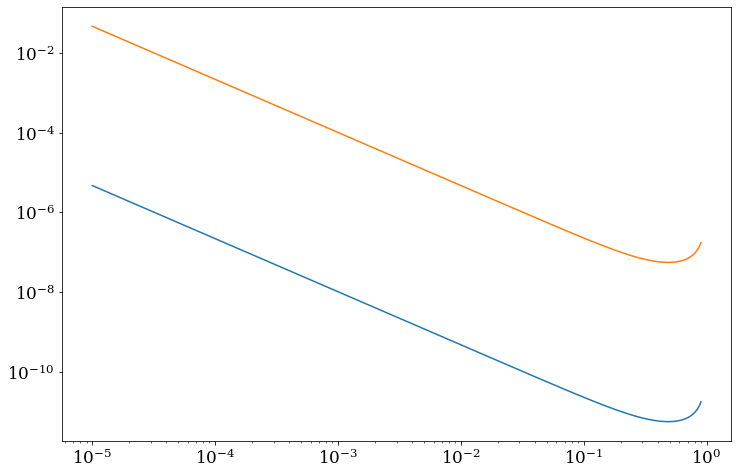

In [159]:
plt.plot(e_L, get_de10_deL(e10=1e-9, eL=e_L))
plt.plot(e_L, get_de10_deL(e10=1e-6, eL=e_L))
plt.xscale('log')
plt.yscale('log')

In [129]:
dat_in = []
for m1, m2, e in zip(M1.flatten(), M1.flatten(), E.flatten()):
    dat_in.append([m1, m2, e])
                     
with MultiPool(processes=100) as pool:
    dat = list(tqdm.tqdm(pool.imap(get_dat_rehash, dat_in), total=len(dat_in)))


100%|██████████| 100/100 [14:11<00:00,  8.52s/it]


In [131]:
horizon_comoving_volume = []
def get_hcv(d):
    t_evol, a_evol, ecc_evol, d_h = d
    redshift = np.ones(len(d_h)) * 1e-8
    redshift[d_h > 0.0001 * u.Mpc] = z_at_value(Planck18.luminosity_distance, d_h[d_h > 0.0001 * u.Mpc])
    return Planck18.comoving_volume(z=redshift)

with MultiPool(processes=128) as pool:
    horizon_comoving_volume = list(tqdm.tqdm(pool.imap(get_hcv, dat), total=len(dat)))


100%|██████████| 100/100 [00:02<00:00, 48.04it/s]


In [132]:
print(len(horizon_comoving_volume), len(dat))

100 100


In [133]:
from utils import get_de10_deL

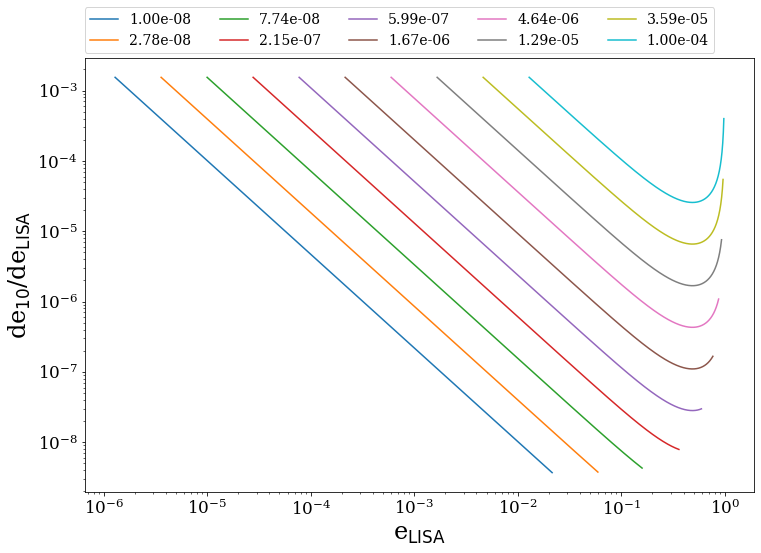

In [181]:
rate_list = []
for ii, d in enumerate(dat):
    e_LIGO = E.flatten()[ii]
    t_evol, a_evol, ecc_evol, d_h = d
    if M1.flatten()[ii] == m1_grid[2]:
        DTDF_ecc = dTmerger_df(M1.flatten()[ii], M1.flatten()[ii], f_orb_evol, ecc_evol)
        rate = get_LIGO_rate_single_e(M1.flatten()[ii], E.flatten()[ii])
        de10deL = get_de10_deL(e10=e_LIGO, eL=ecc_evol)
        plt.plot(ecc_evol, de10deL, label=f"{e_LIGO:.2e}")
    
        rate_per_mass_per_Hz = (rate * (-1) * DTDF_ecc * horizon_comoving_volume[ii] * de10deL).to(u.Msun**(-1) * u.Hz**(-1))
        rate = np.trapz(rate_per_mass_per_Hz, f_orb_evol)
        rate_list.append(rate.value)
plt.legend(ncol=5, loc=(0.0, 1.01), prop={'size':14})
plt.xlabel(r'e$_{\rm{LISA}}$')
plt.ylabel(r'de$_{10}$/de$_{\rm{LISA}}$')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [135]:
print(len(rate_list), len(E))

100 10


In [136]:
rate_list = np.array(rate_list).reshape(E.shape)
np.shape(rate_list), np.shape(E), np.shape(MC)


((10, 10), (10, 10), (10, 10))

4.5961244803080845e-05 solMass
4.596124938472975e-05 solMass
4.5961261024210746e-05 solMass
4.596132567822075e-05 solMass
4.5961925636688835e-05 solMass
4.5970098660186414e-05 solMass
4.227179287469855e-05 solMass
2.9633397938748433e-05 solMass
3.532470820267847e-05 solMass
7.108310555136226e-05 solMass


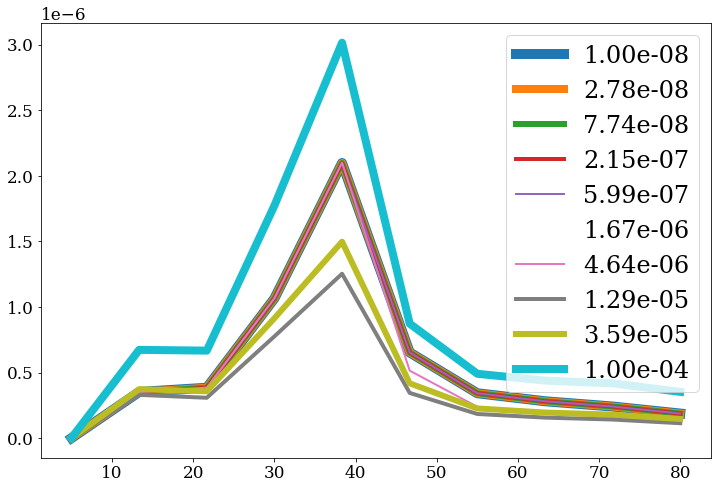

In [137]:
for ii in range(len(ecc)):
    plt.plot(m1_grid, rate_list[:,ii], label=f'{ecc[ii]:.2e}', lw=10-2*ii)
    print(trapz(rate_list[:,ii], m1_grid))
plt.legend()


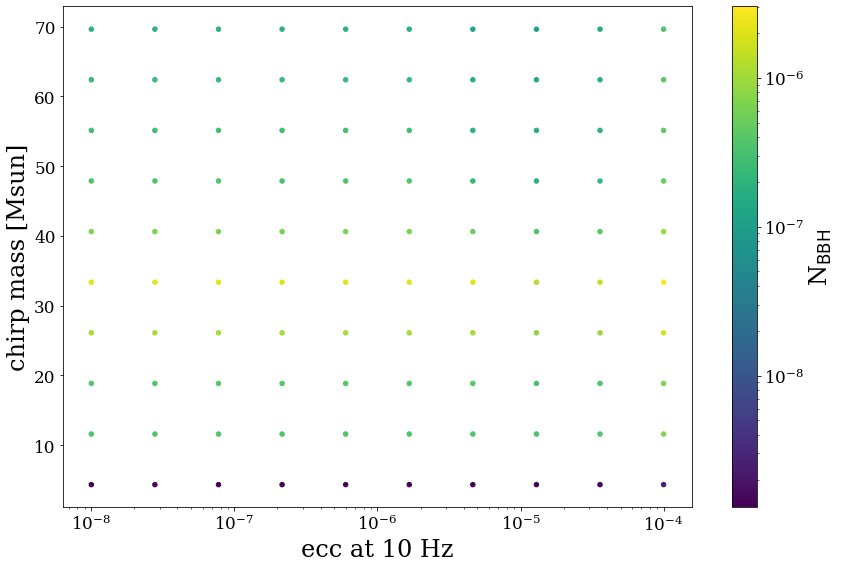

In [138]:
from matplotlib import colors
plt.scatter(E, MC, c=rate_list, norm=colors.LogNorm(), s=20)
plt.colorbar(label=r'N$_{\mathrm{BBH}}$')
plt.xscale('log')
plt.xlabel('ecc at 10 Hz')
plt.ylabel('chirp mass [Msun]')
plt.tight_layout()
plt.savefig('rate_per_chirp_mass.png')

In [139]:
import cmasher as cmr
color_list = cmr.take_cmap_colors('cmr.rainforest', len(ecc), cmap_range=(0.15, 0.85), return_fmt='hex')


In [140]:
len(m1_grid)

10

100%|██████████| 100/100 [00:00<00:00, 4845.77it/s]


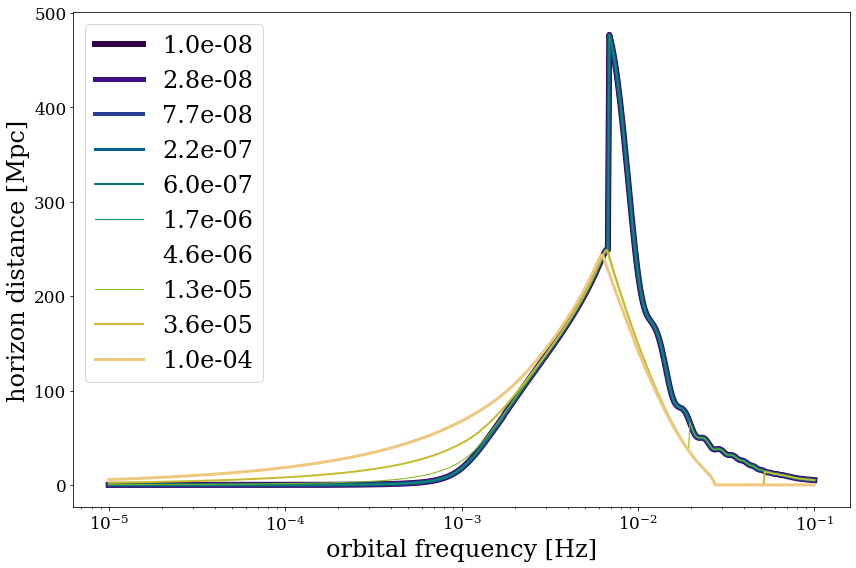

In [142]:
mm = 0
for ii, d in enumerate(tqdm.tqdm(dat)):
    t_evol, a_evol, ecc_evol, d_h = d
    jj, = np.where(E.flatten()[ii] == ecc)
    if (M1.flatten()[ii] == m1_grid[5]) & (E.flatten()[ii] in ecc):
        #print(d_h)
        plt.plot(f_orb_evol, d_h.to(u.Mpc), c=color_list[jj[0]], lw=6-mm, label=f'{E.flatten()[ii]:.1e}')
        mm+=1
    
plt.legend()
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('orbital frequency [Hz]')
plt.ylabel('horizon distance [Mpc]')
plt.tight_layout()
plt.savefig('horizon_ecc.png')

In [103]:
m1_bins

<Quantity [ 4.62121212,  5.37878788,  6.13636364,  6.89393939,  7.65151515,
            8.40909091,  9.16666667,  9.92424242, 10.68181818, 11.43939394,
           12.1969697 , 12.95454545, 13.71212121, 14.46969697, 15.22727273,
           15.98484848, 16.74242424, 17.5       , 18.25757576, 19.01515152,
           19.77272727, 20.53030303, 21.28787879, 22.04545455, 22.8030303 ,
           23.56060606, 24.31818182, 25.07575758, 25.83333333, 26.59090909,
           27.34848485, 28.10606061, 28.86363636, 29.62121212, 30.37878788,
           31.13636364, 31.89393939, 32.65151515, 33.40909091, 34.16666667,
           34.92424242, 35.68181818, 36.43939394, 37.1969697 , 37.95454545,
           38.71212121, 39.46969697, 40.22727273, 40.98484848, 41.74242424,
           42.5       , 43.25757576, 44.01515152, 44.77272727, 45.53030303,
           46.28787879, 47.04545455, 47.8030303 , 48.56060606, 49.31818182,
           50.07575758, 50.83333333, 51.59090909, 52.34848485, 53.10606061,
           5

In [ ]:
dat_ecc_sample = []
for ii, d, h in zip(range(len(dat)), dat, horizon_comoving_volume):
    t_evol, a_evol, ecc_evol, d_h = d
    mass_ind_select, = np.where(m1_grid == M1.flatten()[ii])
        
    DTDF_ecc = dTmerger_df(M1.flatten()[ii], M1.flatten()[ii], f_orb_evol, ecc_evol)
    rate = get_LIGO_rate_single_e(M1.flatten()[ii], E.flatten()[ii])
    #redshift = np.ones(len(d_h)) * 1e-8
    #redshift[d_h > 0.0001 * u.Mpc] = z_at_value(Planck18.luminosity_distance, d_h[d_h > 0.0001 * u.Mpc])
    #horizon_comoving_volume = Planck18.comoving_volume(z=redshift)

    rate_per_mass_per_Hz = (rate * (-1) * DTDF_ecc * h).to(u.Msun**(-1) * u.Hz**(-1))
    rate_per_Hz = rate_per_mass_per_Hz * delta_m1
    f_lo = 0.5e-6 * u.Hz
    e_lo = ecc_evol[0]
    d_samp = []
    m_samp = []
    f_samp = []
    e_samp = []
    e_LIGO = E.flatten()[ii]

    for f, e, r, d in zip(f_orb_evol, ecc_evol, rate_per_Hz, d_h):
        delta_f = f - f_lo
        n_samp = r * delta_f
        n_int = int(n_samp)
            
        n_float = n_samp - n_int
        add_check = np.random.uniform(0, 1)
        if add_check < n_float:
            n_int += 1
        
        if n_int >= 1:
            d_samp.extend(np.random.power(3, n_int) * d.value)
            m_samp.extend(np.random.uniform(m1_bins[mass_ind_select].value, m1_bins[mass_ind_select+1].value, n_int))
            f_samp.extend(np.random.uniform(f_lo.value, f.value, n_int))
            e_samp.extend(np.random.uniform(e_lo, e, n_int))
        
        
    if len(d_samp) == 1:
        dat_ecc_sample.append([d_samp[0], m_samp[0], f_samp[0], e_samp[0], e_LIGO])
    elif len(d_samp) > 2:
        for d, m, f, e in zip(d_samp, m_samp, f_samp, e_samp):
            dat_ecc_sample.append([d, m, f, e, e_LIGO])

In [ ]:
dat_ecc_sample = np.array(dat_ecc_sample)
n_dat_sample = []
for e in ecc:
    dat_count = dat_ecc_sample[dat_ecc_sample[:,4] == e]
    print(np.shape(dat_count))

In [ ]:
plt.plot(ecc, n_dat_sample)
plt.xscale('log')

In [ ]:
rate_list.sum(axis=0)

In [ ]:
plt.figure(figsize=(6,3))
plt.scatter(ecc, rate_list.sum(axis=0))
plt.xscale('log')
#plt.yscale('log')
plt.ylabel(r'N$_{\rm{BBH}}$',)
plt.xlabel(r'e$_{10\,\rm{Hz}}$',)
plt.tight_layout()
plt.savefig('rate_constant_ecc.png')

In [ ]:

plt.scatter(MC, E, c=np.log10(rate_list))
plt.yscale('log')
plt.colorbar()

In [ ]:
source = lw.source.Source(m_1=MASS.flatten(),
                          m_2=MASS.flatten(),
                          ecc=e_evol.flatten(),
                          f_orb=f_evol.flatten(),
                          dist=8 * np.ones(len(F.flatten())) * u.Mpc,
                          interpolate_g=False,
                          n_proc=36)
snr = source.get_snr(approximate_R=True, verbose=True)
D_h = snr/7 * 8 * u.Mpc
redshift = np.ones(len(D_h)) * 1e-8
redshift[D_h > 0.0001 * u.Mpc] = z_at_value(Planck18.luminosity_distance, D_h[D_h > 0.0001 * u.Mpc])
horizon_comoving_volume = Planck18.comoving_volume(z=redshift)
horizon_comoving_volume = horizon_comoving_volume.reshape(MASS.shape)
D_h = D_h.reshape(MASS.shape)

In [ ]:
plt.scatter(F[:,:,0], abs((T_LISA.reshape(F.shape)[:,:,0]).to(u.Myr)), c=MC[:,:,0].value)
plt.colorbar(label=r'chirp mass [M$_{\odot}$]')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('frequency')
plt.ylabel('time to f=10 Hz')
plt.title(r'$\log_{10}(e_{10}) =$'+str(np.log10(ecc[0])), size=20)

In [ ]:
plt.scatter(F[:,:,0], abs((DTDF_ecc.reshape(F.shape)[:,:,0]).to(u.Myr/u.Hz)), c=MC[:,:,0].value)
plt.colorbar(label=r'chirp mass [M$_{\odot}$]')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('frequency')
plt.ylabel(r'dT$_{\rm{merge}}$/df [Myr/Hz]')
plt.title(r'$\log_{10}(e_{10}) =$'+str(np.log10(ecc[0])), size=20)

In [ ]:
e_evol[0,0,4], f_evol[0,0,4]

In [ ]:
np.shape(e_evol)

In [ ]:
plt.scatter(F[:,:,0], D_h[:,:,0], c=MC[:,:,0].value)
#plt.colorbar(label=r'chirp mass [M$_{\odot}$]')
plt.xscale('log')
plt.yscale('log')
#plt.xlabel('frequency')
#plt.ylabel('horizon distance')
#plt.title(r'$\log_{10}(e_{10}) =$'+str(np.log10(ecc[0])), size=20)

In [ ]:
for ii in range(len(ecc)):
    plt.plot(F[5,:,ii], D_h[5,:,ii].to(u.Mpc))#, c=np.log10(e_evol[5,:,ii]), vmin=-4, vmax=1, s=(len(ecc) - ii)*10)
    #plt.colorbar(label=r'ecc')
    plt.xscale('log')
    plt.xlim(1e-5, 1e-1)
    plt.ylim(1e-5, 1000)
    plt.yscale('log')
    plt.xlabel('frequency')
    plt.ylabel('horizon distance [Mpc]')
    plt.show()


In [ ]:
plt.scatter(F[0,:,:], abs((T_LISA.reshape(F.shape)[0,:,:]).to(u.Myr)), c=np.log10(ECC[0,:,:]))
plt.colorbar(label=r'$\log_{10}(e_{10})$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('frequency')
plt.ylabel('time to f=10 Hz')
plt.title(f'mass = {masses[0]} Msun', size=20)

In [ ]:
np.shape(F)

In [ ]:
plt.scatter(F[6,:,:], D_h[6,:,:].to(u.Mpc), c=np.log10(ECC[6,:,:]))
plt.colorbar(label=r'$\log_{10}(e_{10})$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('frequency')
plt.ylabel('Horizon distance [Mpc]')
plt.title(f'mass = {masses[6]} Msun', size=20)

In [ ]:
plt.scatter(F[0,:,:], abs((T_LISA.reshape(F.shape)[0,:,:]).to(u.Myr)), c=np.log10(e_evol[0,:,:]))
plt.colorbar(label=r'$\log_{10}(e_{10})$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('frequency')
plt.ylabel('time to f=10 Hz')
plt.title(f'mass = {masses[0]} Msun', size=20)

In [ ]:
plt.scatter(F[4,:,:], D_h[4,:,:], c=e_evol[4,:,:], vmin=0, vmax=1)
plt.colorbar(label=r'$\log_{10}(e_{10})$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('frequency')
plt.ylabel('horizon distance [Mpc]')
plt.title(f'mass = {np.round(masses[4].value, 2)} Msun', size=20)

In [ ]:
plt.scatter(F, MC, c=np.log10(horizon_comoving_volume.to(u.Gpc**3).value), s=100*e_evol)
plt.xscale('log')
plt.colorbar()

In [ ]:
np.shape(F), len(masses), len(ecc), len(f), np.shape(e_evol)

In [ ]:
RATE_single_ecc = get_LIGO_rate_single_e(MASS, ECC)


In [ ]:
dat = []
rate_per_mass_per_Hz = (RATE.reshape(F.shape) * (-1) * DTDF_ecc.reshape(F.shape) * horizon_comoving_volume).to(u.Msun**(-1) * u.Hz**(-1))
for mm in tqdm.tqdm(range(10)):
    m_samp = []
    e_samp = []
    f_samp = []
    D_samp = []
    for ii, m in enumerate(masses):
        for jj, e in enumerate(ecc[1:]):
            for kk, freq in enumerate(f[1:]):
                
                n_samp = rate_per_mass_per_Hz[ii, kk+1, jj+1] * (mass_bins[ii+1] - mass_bins[ii]) * (f_bins[jj] - f_bins[jj+1])
                #n_per_Gpc3_per_Hz = (RATE.reshape(F.shape)[ii, kk+1, jj+1] * -1 * DTDF_ecc.reshape(F.shape)[ii, kk+1, jj+1].to(u.yr/u.Hz) * d).to(u.Gpc**(-3)/u.Msun/u.Hz)  
                #print(n_per_Gpc3_per_Hz * horizon_comoving_volume[ii, kk+1, jj+1].to(u.Gpc**3))
                #n_per_Hz = n_per_Gpc3_per_Hz * horizon_comoving_volume[ii, kk+1, jj+1].to(u.Gpc**3) * (mass_bins[ii+1] - mass_bins[ii])
                #n_samp = n_per_Hz * (f_bins[jj] - f_bins[jj+1])
                d_lim = D_h[ii, kk+1, jj+1].to(u.Mpc)
                ## Decide on how many sources at this freq, mass to sample 
                n_int = int(n_samp)
                n_float = n_samp - n_int
                add_check = np.random.uniform(0, 1)
                if add_check < n_float:
                    n_int += 1
                if n_int >= 1:
                    d_samp = np.random.power(3, n_int) * d_lim
                    
                    m_samp.extend(np.random.uniform(mass_bins[ii].value, mass_bins[ii+1].value, n_int))
                    e_samp.extend(np.ones(n_int) * e_evol[ii,kk+1,  jj+1])
                    f_samp.extend(np.random.uniform(f_bins[jj+1].value, f_bins[jj].value, n_int))
                    D_samp.extend(d_samp.to(u.Mpc).value)
    dat.append([m_samp, f_samp, e_samp, D_samp])
            

In [ ]:
plt.scatter(F, MC, c=np.log10(rate_per_mass_per_Hz.to(1/u.Msun * 1/u.Hz).value))
plt.xscale('log')
plt.colorbar()

In [ ]:
dat_iso_10 = []
rate_per_mass_per_Hz = ((RATE_iso_10.reshape(F.shape) * u.Gpc**(-3)/u.Msun/u.yr) * (-1) * DTDF_ecc.reshape(F.shape) * horizon_comoving_volume).to(u.Msun**(-1) * u.Hz**(-1))

for mm in tqdm.tqdm(range(10)):
    m_samp = []
    e_samp = []
    f_samp = []
    D_samp = []
    for ii, m in enumerate(masses):
        for jj, e in enumerate(ecc[1:]):
            for kk, freq in enumerate(f[1:]):
                n_samp = rate_per_mass_per_Hz[ii, kk+1, jj+1] * (mass_bins[ii+1] - mass_bins[ii]) * (f_bins[jj] - f_bins[jj+1])
                d_lim = D_h[ii, kk+1, jj+1].to(u.Mpc)
                # Decide on how many sources at this freq, mass to sample 
                n_int = int(n_samp)
                n_float = n_samp - n_int
                add_check = np.random.uniform(0, 1)
                if add_check < n_float:
                    n_int += 1
                if n_int >= 1:
                    d_samp = np.random.power(3, n_int) * d_lim
                    
                    m_samp.extend(np.random.uniform(mass_bins[ii].value, mass_bins[ii+1].value, n_int))
                    e_samp.extend(np.ones(n_int) * e_evol[ii,kk+1,  jj+1])
                    f_samp.extend(np.random.uniform(f_bins[jj+1].value, f_bins[jj].value, n_int))
                    D_samp.extend(d_samp.to(u.Mpc).value)
    dat_iso_10.append([m_samp, f_samp, e_samp, D_samp])
            

In [ ]:
plt.scatter(F, MC, c=np.log10(rate_per_mass_per_Hz.to(1/u.Msun * 1/u.Hz).value), vmin=-1, vmax=1)
plt.xscale('log')
plt.colorbar()

In [ ]:
dat_iso_50 = []
rate_per_mass_per_Hz = ((RATE_iso_50.reshape(F.shape) * u.Gpc**(-3)/u.Msun/u.yr) * (-1) * DTDF_ecc.reshape(F.shape) * horizon_comoving_volume).to(u.Msun**(-1) * u.Hz**(-1))
for mm in tqdm.tqdm(range(10)):
    m_samp = []
    e_samp = []
    f_samp = []
    D_samp = []
    for ii, m in enumerate(masses):
        for jj, e in enumerate(ecc[1:]):
            for kk, freq in enumerate(f[1:]):
                n_samp = rate_per_mass_per_Hz[ii, kk+1, jj+1] * (mass_bins[ii+1] - mass_bins[ii]) * (f_bins[jj] - f_bins[jj+1])
                d_lim = D_h[ii, kk+1, jj+1].to(u.Mpc)
                # Decide on how many sources at this freq, mass to sample 
                n_int = int(n_samp)
                n_float = n_samp - n_int
                add_check = np.random.uniform(0, 1)
                if add_check < n_float:
                    n_int += 1
                if n_int >= 1:
                    d_samp = np.random.power(3, n_int) * d_lim
                    
                    m_samp.extend(np.random.uniform(mass_bins[ii].value, mass_bins[ii+1].value, n_int))
                    e_samp.extend(np.ones(n_int) * e_evol[ii,kk+1,  jj+1])
                    f_samp.extend(np.random.uniform(f_bins[jj+1].value, f_bins[jj].value, n_int))
                    D_samp.extend(d_samp.to(u.Mpc).value)
    dat_iso_50.append([m_samp, f_samp, e_samp, D_samp])
            

In [ ]:
plt.scatter(F, MC, c=np.log10(rate_per_mass_per_Hz.to(1/u.Msun * 1/u.Hz).value), vmin=-1, vmax=4)
plt.xscale('log')
plt.colorbar()

In [ ]:
dat_iso_90 = []
rate_per_mass_per_Hz = ((RATE_iso_90.reshape(F.shape) * u.Gpc**(-3)/u.Msun/u.yr) * (-1) * DTDF_ecc.reshape(F.shape) * horizon_comoving_volume).to(u.Msun**(-1) * u.Hz**(-1))

for mm in tqdm.tqdm(range(10)):
    m_samp = []
    e_samp = []
    f_samp = []
    D_samp = []
    for ii, m in enumerate(masses):
        for jj, e in enumerate(ecc[1:]):
            for kk, freq in enumerate(f[1:]):
                n_samp = rate_per_mass_per_Hz[ii, kk+1, jj+1] * (mass_bins[ii+1] - mass_bins[ii]) * (f_bins[jj] - f_bins[jj+1])
                d_lim = D_h[ii, kk+1, jj+1].to(u.Mpc)
                # Decide on how many sources at this freq, mass to sample 
                n_int = int(n_samp)
                n_float = n_samp - n_int
                add_check = np.random.uniform(0, 1)
                if add_check < n_float:
                    n_int += 1
                if n_int >= 1:
                    d_samp = np.random.power(3, n_int) * d_lim
                    
                    m_samp.extend(np.random.uniform(mass_bins[ii].value, mass_bins[ii+1].value, n_int))
                    e_samp.extend(np.ones(n_int) * e_evol[ii,kk+1,  jj+1])
                    f_samp.extend(np.random.uniform(f_bins[jj+1].value, f_bins[jj].value, n_int))
                    D_samp.extend(d_samp.to(u.Mpc).value)
    dat_iso_90.append([m_samp, f_samp, e_samp, D_samp])
            

In [ ]:
plt.scatter(F, MC, c=np.log10(rate_per_mass_per_Hz.to(1/u.Msun * 1/u.Hz).value))
plt.xscale('log')
plt.colorbar()

In [ ]:
dat_list = [dat, dat_iso_10, dat_iso_50, dat_iso_90]


In [ ]:
fig, axes = plt.subplots(1,len(dat_list), figsize=(20,4))
for dlist, ax, ii in zip(dat_list, axes, range(len(dat_list))):
    print(ii)
    n_obs = []
    for d in dlist[::10]:
        m_samp, f_samp, e_samp, D_samp = d
        n_obs.append(len(m_samp))
        c = ax.scatter(f_samp, lw.utils.chirp_mass(np.array(m_samp), np.array(m_samp)), c=np.log10(e_samp), vmin=-4, vmax=-2, rasterized=True)
    ax.set_xscale('log')
    ax.set_xlim(1e-4, 1e-1)
    ax.set_xlabel('frequency [Hz]')
    if ii == 0:
        ax.set_ylabel('chirp mass [Msun]')
    ax.set_title(r'N$_{\rm{LISA}}$='+str(np.mean(n_obs))+' $\pm$ '+str(np.round(np.std(n_obs), 2)), size=20)
plt.colorbar(c)

In [ ]:
def get_single_ecc(dat_in):
    ecc, RATE_single_ecc, F, DTDF_ecc, horizon_comoving_volume, D_h, e_evol, ecc, masses, f, mass_bins= dat_in
    rate_per_mass_per_Hz = ((RATE_single_ecc.reshape(F.shape)) * (-1) * DTDF_ecc.reshape(F.shape) * horizon_comoving_volume).to(u.Msun**(-1) * u.Hz**(-1))
    dat_samp = []
    for jj, e in enumerate(ecc[1:]):
        m_samp = []
        e_samp = []
        f_samp = []
        D_samp = []
        for ii, m in enumerate(masses):
            for kk, freq in enumerate(f[1:]):
                n_samp = rate_per_mass_per_Hz[ii, kk+1, jj+1] * (mass_bins[ii+1] - mass_bins[ii]) * (f_bins[jj] - f_bins[jj+1])
                
                d_lim = D_h[ii, kk+1, jj+1]
                # Decide on how many sources at this freq, mass to sample 
                n_int = int(n_samp)
                n_float = n_samp - n_int
                add_check = np.random.uniform(0, 1)
                if add_check < n_float:
                    n_int += 1
                if n_int >= 1:
                    d_samp = np.random.power(3, n_int) * d_lim
                    
                    m_samp.extend(np.random.uniform(mass_bins[ii].value, mass_bins[ii+1].value, n_int))
                    e_samp.extend(np.ones(n_int) * e_evol[ii,kk+1,  jj+1])
                    f_samp.extend(freq.value * np.ones(n_int))
                    D_samp.extend(d_samp.to(u.Mpc).value)
        dat_samp.append([m_samp, f_samp, e_samp, D_samp])
    return dat_samp

In [ ]:
rate_per_mass_per_Hz = ((RATE_single_ecc.reshape(F.shape)) * (-1) * DTDF_ecc.reshape(F.shape) * horizon_comoving_volume).to(u.Msun**(-1) * u.Hz**(-1))
dat_ecc = []
for ii in tqdm.tqdm(range(20)):
    dat_samp = []
    for jj, e in enumerate(ecc[1:]):
        m_samp = []
        e_samp = []
        f_samp = []
        D_samp = []
        for ii, m in enumerate(masses):
            for kk, freq in enumerate(f[1:]):
                n_samp = rate_per_mass_per_Hz[ii, kk+1, jj+1] * (mass_bins[ii+1] - mass_bins[ii]) * (f_bins[jj] - f_bins[jj+1])
                
                d_lim = D_h[ii, kk+1, jj+1]
                # Decide on how many sources at this freq, mass to sample 
                n_int = int(n_samp)
                n_float = n_samp - n_int
                add_check = np.random.uniform(0, 1)
                if add_check < n_float:
                    n_int += 1
                if n_int >= 1:
                    d_samp = np.random.power(3, n_int) * d_lim
                    
                    m_samp.extend(np.random.uniform(mass_bins[ii].value, mass_bins[ii+1].value, n_int))
                    e_samp.extend(np.ones(n_int) * e_evol[ii,kk+1,  jj+1])
                    f_samp.extend(np.random.uniform(f_bins[ii+1].value, f_bins[ii].value, n_int))
                    D_samp.extend(d_samp.to(u.Mpc).value)
        dat_samp.append([m_samp, f_samp, e_samp, D_samp])
    dat_ecc.append(dat_samp)

In [ ]:
#dat_in_single_ecc = []
#for ii in range(20):
#    dat_in_single_ecc.append([ecc, RATE_single_ecc, F, DTDF_ecc, horizon_comoving_volume, D_h, e_evol, ecc, masses, f, mass_bins])

In [ ]:
#with MultiPool(processes=20) as pool:
#    dat_ecc = list(pool.map(get_single_ecc, dat_in_single_ecc))
#
#

In [ ]:
#dat_ecc = []
#for ii in tqdm.tqdm(range(500)):
#    dat_samp = []
#    for jj, e in enumerate(ecc[1:]):
#        m_samp = []
#        e_samp = []
#        f_samp = []
#        D_samp = []
#        for ii, m in enumerate(masses):
#            for kk, freq in enumerate(f[1:]):
#                n_per_Gpc3 = (RATE_single_ecc.reshape(F.shape)[ii, kk+1, jj+1] * -1 * T_LISA.reshape(F.shape)[ii, kk+1, jj+1]).to(u.Gpc**(-3)/u.Msun)  
#                n_samp = n_per_Gpc3 * horizon_comoving_volume[ii, kk+1, jj+1] * delta_m * u.Msun
#                
#                d_lim = D_h[ii, kk+1, jj+1]
#                # Decide on how many sources at this freq, mass to sample 
#                n_int = int(n_samp)
#                n_float = n_samp - n_int
#                add_check = np.random.uniform(0, 1)
#                if add_check < n_float:
#                    n_int += 1
#                if n_int >= 1:
#                    d_samp = np.random.power(3, n_int) * d_lim
#                    
#                    m_samp.extend(np.random.uniform(mass_bins[ii].value, mass_bins[ii+1].value, n_int))
#                    e_samp.extend(np.ones(n_int) * e_evol[ii,kk+1,  jj+1])
#                    f_samp.extend(np.random.uniform(f_bins[jj+1].value, f_bins[jj].value, n_int))
#                    D_samp.extend(d_samp.to(u.Mpc).value)
#        dat_samp.append([m_samp, f_samp, e_samp, D_samp])
#    dat_ecc.append(dat_samp)
#            

In [ ]:
len(dat_ecc)

In [ ]:
import cmasher as cmr
colors = cmr.take_cmap_colors('cmr.rainforest', 9, cmap_range=(0.15, 0.85), return_fmt='hex')


In [ ]:
n_ecc_list = []
for de in dat_ecc:
    n_ecc = []
    for ii, d in enumerate(de):
        m_samp, f_samp, e_samp, D_samp = d
        
        
        #plt.scatter(f_samp, m_samp, c=np.log10(ecc[ii]) * np.ones(len(f_samp)), vmin=-8, vmax=-4)
        n_ecc.append(len(m_samp))
    n_ecc_list.append(n_ecc)

In [ ]:
n_ecc_list = np.array(n_ecc_list)
np.shape(n_ecc_list)

In [ ]:
mean = []
std = []
for ii in range(len(ecc)-1):
    mean.append(np.mean(np.array(n_ecc_list[:,ii])))
    std.append(np.std(np.array(n_ecc_list[:,ii])))

In [ ]:
for ii, e in enumerate(ecc[1:]):
    plt.hist(n_ecc[:, ii], bins=np.arange(0, 7, 1), histtype='step', density=True, label=r'$\log_{10}e_{10}=$'+str(np.round(np.log10(e), 2)))

plt.legend(prop={'size':14})
                    

In [ ]:
plt.errorbar(ecc[1:], mean, std)
#plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'e$_{10}$')
plt.ylabel(r'N$_{\rm{LISA}}$')
plt.yscale('log')

In [ ]:
n_grid_f = 100
n_grid_e = 5
n_grid_mass = 15

f = np.logspace(-1, -4, n_grid) * u.Hz
f_bins = f[:-1] - f[1:]

masses = np.linspace(5, 80, n_grid_mass)
m_bin_widths = masses[1] - masses[0]
mass_bins = masses - 0.5 * m_bin_widths
mass_bins = np.append(mass_bins, masses[-1] + 0.5 * m_bin_widths)
masses = masses * u.Msun
mass_bins = mass_bins * u.Msun

ecc = np.linspace(0, 0.0001, n_grid_e)
ecc_bins = ecc[1:] - ecc[:-1]

m_c = lw.utils.chirp_mass(masses, masses)
F, MASS, ECC = np.meshgrid(f, masses, ecc)

MC = lw.utils.chirp_mass(MASS, MASS)

RATE = get_LIGO_rate_uniform_e(MASS, ECC, ecc)
RATE_iso_10 = get_LIGO_rate_iso_dyn(MASS, ECC, ecc, 0.1)
RATE_iso_50 = get_LIGO_rate_iso_dyn(MASS, ECC, ecc, 0.5)
RATE_iso_90 = get_LIGO_rate_iso_dyn(MASS, ECC, ecc, 0.9)

In [ ]:
V_c = []
LIGO_rate_uniform = []
LIGO_rate_iso_dyn_50 = []
LIGO_rate_iso_dyn_80 = []
times = []
ecc_evols = []
f_orb_evols = []
LISA_norms = []
m1_evols = []
m2_evols = []


for d, m1, m2, e in tqdm.tqdm(zip(dat_out, M1, M2, E), total=len(M1)):
    f_orb_evol, ecc_evol, timesteps, LISA_norm = d
    f_mask = f_orb_evol < 0.3 * u.Hz
    source = lw.source.Source(m_1=m1 * np.ones(len(f_orb_evol[f_mask])) * u.Msun,
                              m_2=m2 * np.ones(len(f_orb_evol[f_mask])) * u.Msun,
                              ecc=ecc_evol[f_mask],
                              f_orb=f_orb_evol[f_mask],
                              dist=8 * np.ones(len(f_orb_evol[f_mask])) * u.Mpc,
                              interpolate_g=False,
                              n_proc=nproc)
    snr = source.get_snr(approximate_R=True, verbose=False)
    D_h = snr/7 * 8 * u.Mpc
    redshift = np.ones(len(D_h)) * 1e-8
    redshift[D_h > 0.0001 * u.Mpc] = z_at_value(Planck18.luminosity_distance, D_h[D_h > 0.0001 * u.Mpc])
    V_c.append(Planck18.comoving_volume(z=redshift))

    LISA_norms.append(LISA_norm[f_mask].to(u.yr/u.Hz))
    times.append(-timesteps[f_mask].to(u.yr))
    ecc_evols.append(ecc_evol[f_mask])
    f_orb_evols.append(f_orb_evol[f_mask])
    m1_evols.append(m1 * np.ones(len(f_orb_evol[f_mask])))
    m2_evols.append(m2 * np.ones(len(f_orb_evol[f_mask])))
    LIGO_rate_uniform.append(get_LIGO_rate_uniform_e(m1, delta_m[0]))
    LIGO_rate_iso_dyn_50.append(get_LIGO_rate_iso_dyn(m1, e, frac_iso=0.5))
    LIGO_rate_iso_dyn_80.append(get_LIGO_rate_iso_dyn(m1, e, frac_iso=0.8))


In [ ]:
def get_m_lo(m1, mass_grid):
    return min(mass_grid[mass_grid < m1])
    

In [ ]:
print(n_grid)
m1_keep = []
m2_keep = []
f_keep = []
for ii, m1, m2 in zip(range(len(M1)), M1, M2):
    print(m1, m2)
    ligo_rate = get_LIGO_rate_uniform_e(m1, delta_m[0]) / n_grid
    f = f_orb_evols[ii]
    v_c = V_c[ii]
    
    l_norm = LISA_norms[ii] * (u.yr/u.Hz)
    t_evol = times[ii]
    
    # first select out everything that's below a millihertz
    ind_mhz, = np.where(f < 0.001 * u.Hz)
    ind_mhz_gtr, = np.where(f >= 0.001 * u.Hz)
        
    t_max_lo = max(t_evol[ind_mhz])
    v_max_lo = max(v_c[ind_mhz].to(u.Mpc**3))
    n_sample_lo = int(ligo_rate.to(u.Mpc**(-3)/u.yr) * v_max_lo * t_max_lo)
    t_f_interp = interp1d(t_evol[ind_mhz], f[ind_mhz])
    v_c_interp = interp1d(f[ind_mhz], v_c[ind_mhz])
    
    m_lo = get_m_lo(m1, mass1_grid)
    m1_sample = np.random.uniform(m_lo, m1, n_sample_lo)
    m2_sample = np.random.uniform(5 * np.ones(n_sample_lo), m1_sample)
    t_sample = np.random.uniform(min(t_evol[ind_mhz]).value, t_max_lo.value, n_sample_lo)
    f_sample = t_f_interp(t_sample)
    v_max = v_c_interp(f_sample)
    d_max = 3/(4 * np.pi) * v_max_lo**(1/3)
    
    d = np.random.power(3, n_sample_lo) * (3/(4 * np.pi) * max(v_c[ind_mhz].value))**(1/3) * u.Mpc
    source = lw.source.Source(m_1=m1_sample * u.Msun,
                              m_2=m2_sample * u.Msun,
                              ecc=np.zeros(len(m1_sample)),
                              f_orb=f_sample * u.Hz,
                              dist=8 * np.ones(len(f_sample)) * u.Mpc,
                              interpolate_g=False,
                              n_proc=nproc)
    snr = source.get_snr(approximate_R=True, verbose=False)
    keep_mask = snr  > 7
    m1_keep.extend(m1_sample[keep_mask])
    m2_keep.extend(m2_sample[keep_mask])
    f_keep.extend(f_sample[keep_mask])
    print(f"sample {n_sample_lo} mergers below 1 mHz and keep {len(keep_mask[keep_mask])} of them")
    
    t_max = max(t_evol[ind_mhz_gtr])
    v_max = max(v_c[ind_mhz_gtr].to(u.Mpc**3))
    n_sample = int(ligo_rate.to(u.Mpc**(-3)/u.yr) * v_max * t_max)
    
    
    t_f_interp = interp1d(t_evol[ind_mhz_gtr], f[ind_mhz_gtr])
    v_c_interp = interp1d(f[ind_mhz_gtr], v_c[ind_mhz_gtr])
    m_lo = get_m_lo(m1, mass1_grid)
    m1_sample = np.random.uniform(m_lo, m1, n_sample)
    m2_sample = np.random.uniform(5 * np.ones(n_sample), m1_sample)
    t_sample = np.random.uniform(0, t_max.value, n_sample)
    f_sample = t_f_interp(t_sample)
    v_max = v_c_interp(f_sample)
    d_max = 3/(4 * np.pi) * v_max**(1/3)
    
    d = np.random.power(3, n_sample) * (3/(4 * np.pi) * max(v_c.value))**(1/3)
    d = np.random.power(3, n_sample_lo) * (3/(4 * np.pi) * max(v_c[ind_mhz].value))**(1/3) * u.Mpc
    source = lw.source.Source(m_1=m1_sample * u.Msun,
                              m_2=m2_sample * u.Msun,
                              ecc=np.zeros(len(m1_sample)),
                              f_orb=f_sample * u.Hz,
                              dist=8 * np.ones(len(f_sample)) * u.Mpc,
                              interpolate_g=False,
                              n_proc=nproc)
    snr = source.get_snr(approximate_R=True, verbose=False)
    keep_mask = snr  > 7
    m1_keep.extend(m1_sample[keep_mask])
    m2_keep.extend(m2_sample[keep_mask])
    f_keep.extend(f_sample[keep_mask])
    print(f"sample {n_sample} mergers above 1 mHz and keep {len(keep_mask[keep_mask])} of them")
    print()


In [ ]:
m_c = lw.utils.chirp_mass(m1_keep * u.Msun, m2_keep * u.Msun)
print(len(m_c))

In [ ]:
m_c = lw.utils.chirp_mass(m1_keep * u.Msun, m2_keep * u.Msun)
print(len(m_c))

In [ ]:
plt.scatter(f_keep, m_c)
plt.xscale('log')

In [ ]:
m_c = lw.utils.chirp_mass(m1_keep * u.Msun, m2_keep * u.Msun)
print(len(m_c))

In [ ]:
plt.scatter(f_keep, m_c)
plt.xscale('log')